## Import libraries

In [1]:
from pyspark.sql import *
from pyspark.sql.session import SparkSession
spark = SparkSession.builder.master("local[*]").appName("jdbc data sources").getOrCreate()

## Create DataFrames from a list of the rows

In [2]:
# Create the Departments
department1 = Row(id='123456', name='Computer Science')
department2 = Row(id='789012', name='Mechanical Engineering')
department3 = Row(id='345678', name='Theater and Drama')
department4 = Row(id='901234', name='Indoor Recreation')

In [3]:
# Create the Employees
Employee = Row("firstName", "lastName", "email", "salary")
employee1 = Employee('michael', 'armbrust', 'no-reply@berkeley.edu', 100000)
employee2 = Employee('xiangrui', 'meng', 'no-reply@stanford.edu', 120000)
employee3 = Employee('matei', None, 'no-reply@waterloo.edu', 140000)
employee4 = Employee(None, 'wendell', 'no-reply@berkeley.edu', 160000)
employee5 = Employee('michael', 'jackson', 'no-reply@neverla.nd', 80000)

In [4]:
# Create the DepartmentWithEmployees instances from Departments and Employees
departmentWithEmployees1 = Row(department=department1, employees=[employee1, employee2])
departmentWithEmployees2 = Row(department=department2, employees=[employee3, employee4])
departmentWithEmployees3 = Row(department=department3, employees=[employee5, employee4])
departmentWithEmployees4 = Row(department=department4, employees=[employee2, employee3])

In [5]:
print(department1)
print(employee2)
print(departmentWithEmployees1.employees[0].email)

Row(id='123456', name='Computer Science')
Row(firstName='xiangrui', lastName='meng', email='no-reply@stanford.edu', salary=120000)
no-reply@berkeley.edu


In [6]:
departmentsWithEmployeesSeq1 = [departmentWithEmployees1, departmentWithEmployees2]
df1 = spark.createDataFrame(departmentsWithEmployeesSeq1)

display(df1)

departmentsWithEmployeesSeq2 = [departmentWithEmployees3, departmentWithEmployees4]
df2 = spark.createDataFrame(departmentsWithEmployeesSeq2)

display(df2)

DataFrame[department: struct<id:string,name:string>, employees: array<struct<firstName:string,lastName:string,email:string,salary:bigint>>]

DataFrame[department: struct<id:string,name:string>, employees: array<struct<firstName:string,lastName:string,email:string,salary:bigint>>]

## Work with DataFrames

In [7]:
unionDF = df1.unionAll(df2)
display(unionDF)

DataFrame[department: struct<id:string,name:string>, employees: array<struct<firstName:string,lastName:string,email:string,salary:bigint>>]

In [8]:
df1.select("department").show()

+--------------------+
|          department|
+--------------------+
|[123456, Computer...|
|[789012, Mechanic...|
+--------------------+



### Write the unioned DataFrame to a Parquet file

In [9]:
#Union two DataFrames
unionDF.write.mode("overwrite").parquet("tmp/databricks-df-example.parquet")

### Read a DataFrame from the Parquet file

In [10]:
parquetDF = spark.read.parquet("tmp/databricks-df-example.parquet")
display(parquetDF)

DataFrame[department: struct<id:string,name:string>, employees: array<struct<firstName:string,lastName:string,email:string,salary:bigint>>]

In [11]:
unionDF.show()

+--------------------+--------------------+
|          department|           employees|
+--------------------+--------------------+
|[123456, Computer...|[[michael, armbru...|
|[789012, Mechanic...|[[matei,, no-repl...|
|[345678, Theater ...|[[michael, jackso...|
|[901234, Indoor R...|[[xiangrui, meng,...|
+--------------------+--------------------+



### Explode the employees column

In [12]:
from pyspark.sql.functions import explode

explodeDF = unionDF.select(explode("employees").alias("e"))
flattenDF = explodeDF.selectExpr("e.firstName", "e.lastName", "e.email", "e.salary")

flattenDF.show()

+---------+--------+--------------------+------+
|firstName|lastName|               email|salary|
+---------+--------+--------------------+------+
|  michael|armbrust|no-reply@berkeley...|100000|
| xiangrui|    meng|no-reply@stanford...|120000|
|    matei|    null|no-reply@waterloo...|140000|
|     null| wendell|no-reply@berkeley...|160000|
|  michael| jackson| no-reply@neverla.nd| 80000|
|     null| wendell|no-reply@berkeley...|160000|
| xiangrui|    meng|no-reply@stanford...|120000|
|    matei|    null|no-reply@waterloo...|140000|
+---------+--------+--------------------+------+



## Use filter() to return the rows that match a predicate

In [13]:
filterDF = flattenDF.filter(flattenDF.firstName == "xiangrui").sort(flattenDF.lastName)
display(filterDF)

DataFrame[firstName: string, lastName: string, email: string, salary: bigint]

In [14]:
from pyspark.sql.functions import col, asc

# Use `|` instead of `or`
filterDF = flattenDF.filter((col("firstName") == "xiangrui") | (col("firstName") == "michael")).sort(asc("lastName"))
display(filterDF)

DataFrame[firstName: string, lastName: string, email: string, salary: bigint]

In [15]:
filterDF.show()

+---------+--------+--------------------+------+
|firstName|lastName|               email|salary|
+---------+--------+--------------------+------+
|  michael|armbrust|no-reply@berkeley...|100000|
|  michael| jackson| no-reply@neverla.nd| 80000|
| xiangrui|    meng|no-reply@stanford...|120000|
| xiangrui|    meng|no-reply@stanford...|120000|
+---------+--------+--------------------+------+



### The where() clause is equivalent to filter()

In [18]:
whereDF = flattenDF.where((col("firstName") == "xiangrui") | (col("firstName") == "michael")).sort(asc("lastName"))
display(whereDF)

DataFrame[firstName: string, lastName: string, email: string, salary: bigint]

### Replace null values with -- using DataFrame Na function

In [20]:
nonNullDF = flattenDF.fillna("--")
display(nonNullDF)

DataFrame[firstName: string, lastName: string, email: string, salary: bigint]

In [21]:
nonNullDF.show()

+---------+--------+--------------------+------+
|firstName|lastName|               email|salary|
+---------+--------+--------------------+------+
|  michael|armbrust|no-reply@berkeley...|100000|
| xiangrui|    meng|no-reply@stanford...|120000|
|    matei|      --|no-reply@waterloo...|140000|
|       --| wendell|no-reply@berkeley...|160000|
|  michael| jackson| no-reply@neverla.nd| 80000|
|       --| wendell|no-reply@berkeley...|160000|
| xiangrui|    meng|no-reply@stanford...|120000|
|    matei|      --|no-reply@waterloo...|140000|
+---------+--------+--------------------+------+



### Retrieve only rows with missing firstName or lastName

In [22]:
filterNonNullDF = flattenDF.filter(col("firstName").isNull() | col("lastName").isNull()).sort("email")
display(filterNonNullDF)

DataFrame[firstName: string, lastName: string, email: string, salary: bigint]

In [23]:
filterNonNullDF.show()

+---------+--------+--------------------+------+
|firstName|lastName|               email|salary|
+---------+--------+--------------------+------+
|     null| wendell|no-reply@berkeley...|160000|
|     null| wendell|no-reply@berkeley...|160000|
|    matei|    null|no-reply@waterloo...|140000|
|    matei|    null|no-reply@waterloo...|140000|
+---------+--------+--------------------+------+



### Example aggregations using agg() and countDistinct()

In [24]:
from pyspark.sql.functions import countDistinct

countDistinctDF = nonNullDF.select("firstName", "lastName")\
  .groupBy("firstName")\
  .agg(countDistinct("lastName").alias("distinct_last_names"))

display(countDistinctDF)

DataFrame[firstName: string, distinct_last_names: bigint]

In [25]:
countDistinctDF.show()

+---------+-------------------+
|firstName|distinct_last_names|
+---------+-------------------+
| xiangrui|                  1|
|    matei|                  1|
|  michael|                  2|
|       --|                  1|
+---------+-------------------+



### Compare the DataFrame and SQL query physical plans

In [26]:
countDistinctDF.explain()

== Physical Plan ==
*(5) HashAggregate(keys=[firstName#71], functions=[count(distinct lastName#72)])
+- Exchange hashpartitioning(firstName#71, 200)
   +- *(4) HashAggregate(keys=[firstName#71], functions=[partial_count(distinct lastName#72)])
      +- *(4) HashAggregate(keys=[firstName#71, lastName#72], functions=[])
         +- Exchange hashpartitioning(firstName#71, lastName#72, 200)
            +- *(3) HashAggregate(keys=[firstName#71, lastName#72], functions=[])
               +- *(3) Project [coalesce(e#31.firstName, --) AS firstName#71, coalesce(e#31.lastName, --) AS lastName#72]
                  +- Generate explode(employees#1), false, [e#31]
                     +- Union
                        :- *(1) Project [employees#1]
                        :  +- Scan ExistingRDD[department#0,employees#1]
                        +- *(2) Project [employees#5]
                           +- Scan ExistingRDD[department#4,employees#5]


In [27]:
# register the DataFrame as a temp table so that we can query it using SQL
nonNullDF.createOrReplaceTempView("databricks_df_example")

# Perform the same query as the DataFrame above and return ``explain``
countDistinctDF_sql = spark.sql('''
  SELECT firstName, count(distinct lastName) AS distinct_last_names
  FROM databricks_df_example
  GROUP BY firstName
''')

countDistinctDF_sql.explain()

== Physical Plan ==
*(5) HashAggregate(keys=[firstName#71], functions=[count(distinct lastName#72)])
+- Exchange hashpartitioning(firstName#71, 200)
   +- *(4) HashAggregate(keys=[firstName#71], functions=[partial_count(distinct lastName#72)])
      +- *(4) HashAggregate(keys=[firstName#71, lastName#72], functions=[])
         +- Exchange hashpartitioning(firstName#71, lastName#72, 200)
            +- *(3) HashAggregate(keys=[firstName#71, lastName#72], functions=[])
               +- *(3) Project [coalesce(e#31.firstName, --) AS firstName#71, coalesce(e#31.lastName, --) AS lastName#72]
                  +- Generate explode(employees#1), false, [e#31]
                     +- Union
                        :- *(1) Project [employees#1]
                        :  +- Scan ExistingRDD[department#0,employees#1]
                        +- *(2) Project [employees#5]
                           +- Scan ExistingRDD[department#4,employees#5]


### Sum up all the salaries

In [28]:
salarySumDF = nonNullDF.agg({"salary" : "sum"})
display(salarySumDF)
salarySumDF.show()

DataFrame[sum(salary): bigint]

+-----------+
|sum(salary)|
+-----------+
|    1020000|
+-----------+



In [29]:
type(nonNullDF.salary)

pyspark.sql.column.Column

### Print the summary statistics for the salaries

In [31]:
nonNullDF.describe("salary").show()

+-------+------------------+
|summary|            salary|
+-------+------------------+
|  count|                 8|
|   mean|          127500.0|
| stddev|28157.719063467175|
|    min|             80000|
|    max|            160000|
+-------+------------------+



### An example using pandas and Matplotlib integration

<Figure size 432x288 with 0 Axes>

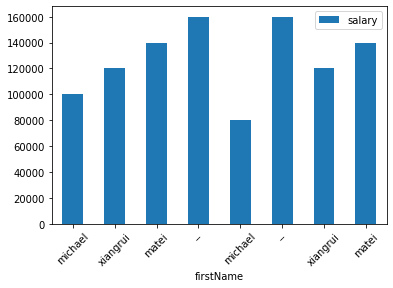

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
plt.clf()
pdDF = nonNullDF.toPandas()
pdDF.plot(x='firstName', y='salary', kind='bar', rot=45)
display()